In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
class NYCSalesPreprocessor:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
    def drop_columns(self, columns):
        self.df.drop(columns=columns, inplace=True)
    def convert_to_numeric(self, columns):
        for col in columns:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
    def convert_to_datetime(self, columns):
        for col in columns:
            self.df[col] = pd.to_datetime(self.df[col], errors='coerce')
    def replace_with(self, column, value_to_replace,value):
        self.df[column].replace(value_to_replace, value, inplace=True)
    def fill_missing_values(self, columns, method='median'):
        for col in columns:
            if method == 'median':
                self.df[col].fillna(self.df[col].median(), inplace=True)
            elif method == 'mean':
                self.df[col].fillna(self.df[col].mean(), inplace=True)
            elif method == 'mode':
                self.df[col].fillna(self.df[col].mode()[0], inplace=True)  
    def drop_missing_values(self, subset_columns):
        self.df.dropna(subset=subset_columns, inplace=True)
    def convert_to_categorical(self, columns):
        for col in columns:
            self.df[col] = self.df[col].astype('category')
    def map_values(self, column, mapping_dict):
        self.df[column] = self.df[column].map(mapping_dict)
        #self.df[column].replace(mapping_dict, inplace=True)
    def extract_datetime_features(self, datetime_column, features):
        for feature in features:
            if feature == 'year':
                self.df[f'{datetime_column}_year'] = self.df[datetime_column].dt.year
            elif feature == 'month':
                self.df[f'{datetime_column}_month'] = self.df[datetime_column].dt.month
            elif feature == 'day':
                self.df[f'{datetime_column}_day'] = self.df[datetime_column].dt.day
    def remove_outliers(self, column, threshold, condition='greater_than'):
        if condition == 'greater_than':
            self.df = self.df[self.df[column] > threshold]
        elif condition == 'less_than':
            self.df = self.df[self.df[column] < threshold]
        else:
            raise ValueError("Invalid condition. Use 'greater_than' or 'less_than'.")
    def rename_columns(self):
        self.df.rename(columns=lambda x: x.strip().replace(' ', '_').lower(), inplace=True)
    def preprocess(self):
        self.drop_columns(['Unnamed: 0'])
        self.convert_to_numeric(['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET'])
        self.convert_to_datetime(['SALE DATE'])
        self.replace_with('SALE PRICE', '-',np.nan)
        self.replace_with('SALE PRICE', '',np.nan)
        self.drop_missing_values(['SALE PRICE'])
        self.fill_missing_values(['LAND SQUARE FEET', 'GROSS SQUARE FEET'], method='median')
        #self.convert_to_categorical(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 
                                     #'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE'])
        borough_mapping = {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'}
        self.map_values('BOROUGH', borough_mapping)
        self.extract_datetime_features('SALE DATE', ['year', 'month'])
        #self.remove_outliers('SALE PRICE', 500000000, condition='less_than')
        #self.remove_outliers('SALE PRICE', 50000, condition='greater_than')
        self.rename_columns()
    
    def save_cleaned_data(self, output_path):
        self.df.to_csv(output_path, index=False)
    def get_cleaned_data(self):
        return self.df

In [2]:
preprocessor = NYCSalesPreprocessor('data/nyc-rolling-sales.csv')
preprocessor.preprocess()
data = preprocessor.get_cleaned_data()

In [3]:
data =  data[(data['sale_price'] <3000000) #limit $5,000,000 
                       & (data['sale_price'] > 1000)
                       & (data['residential_units'] < 500) #limit up to 500 units
                       & (data['commercial_units'] < 500) #limit up to 500 units
                       & (data['gross_square_feet'] < 800000) ]

In [4]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = data.select_dtypes(include=['object','category']).columns
# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in categorical_columns:
    data.loc[:,column] = label_encoder.fit_transform(data[column])

In [5]:
new_housing = data.copy()

In [6]:
data = data.apply(pd.to_numeric, errors='coerce')

In [7]:
corr_columns = data.corr()['sale_price'].sort_values(ascending=False)
#dropped_columns = corr_columns[(corr_columns < 0.05) & (corr_columns > -0.05)].index
#data.drop(dropped_columns, axis=1, inplace=True)
data.corr()['sale_price'].sort_values(ascending=False)

sale_price                        1.000000
building_class_at_time_of_sale    0.225459
building_class_at_present         0.215320
apartment_number                  0.181073
lot                               0.177230
building_class_category           0.152555
tax_class_at_present              0.129429
tax_class_at_time_of_sale         0.116538
sale_date                         0.056369
commercial_units                  0.050317
sale_date_year                    0.043818
total_units                       0.034548
residential_units                 0.029333
gross_square_feet                 0.008598
land_square_feet                  0.004015
address                          -0.001601
neighborhood                     -0.004177
sale_date_month                  -0.015684
year_built                       -0.046942
zip_code                         -0.089431
borough                          -0.133516
block                            -0.301950
ease-ment                              NaN
Name: sale_

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
xgbt = XGBRegressor()
lm = LinearRegression()
ridge = Ridge()
lasso = Lasso()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
dtree = DecisionTreeRegressor()
mlp = MLPRegressor()
algo = [xgbt,lm,ridge,lasso,knn,rf,dtree,mlp]
result = []
X = data.drop(columns=['sale_price'])
y = data['sale_price']
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1,1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for i in algo:
    start = time.process_time()
    model = i.fit(X_train,y_train)
    result.append([str(i).split("(")[0] + str("_processed"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
    print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sec")
        
result_second_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")


XGBRegressor ✓     2.390625 sec
LinearRegression ✓     0.5625 sec
Ridge ✓     0.4375 sec
Lasso ✓     0.03125 sec
KNeighborsRegressor ✓     26.34375 sec
RandomForestRegressor ✓     38.734375 sec
DecisionTreeRegressor ✓     0.546875 sec
MLPRegressor ✓     19.234375 sec


c:\Users\tayla\Platform_Management_Tool_Virtual\.virtual_tool_man\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
result_second_model

,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
RandomForestRegressor_processed,0.948462,0.604732,0.227645,0.621720,0.140507,0.385665
XGBRegressor_processed,0.752272,0.587756,0.499093,0.634930,0.329190,0.403925
MLPRegressor_processed,0.537800,0.466237,0.681724,0.722475,0.452124,0.477133
KNeighborsRegressor_processed,0.633794,0.422327,0.606815,0.751605,0.392071,0.488689
DecisionTreeRegressor_processed,0.999451,0.307323,0.023504,0.823027,0.000896,0.500182
LinearRegression_processed,0.139690,0.134536,0.930082,0.919969,0.688910,0.682756
Ridge_processed,0.139652,0.134314,0.930102,0.920087,0.689001,0.682876
Lasso_processed,0.000000,-0.000061,1.002752,0.988922,0.740093,0.731747


**With more linearized data**

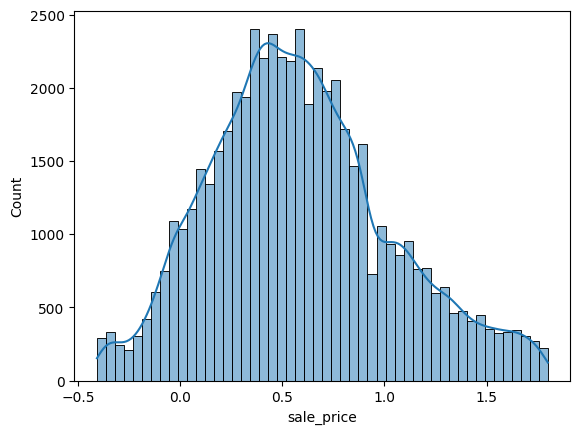

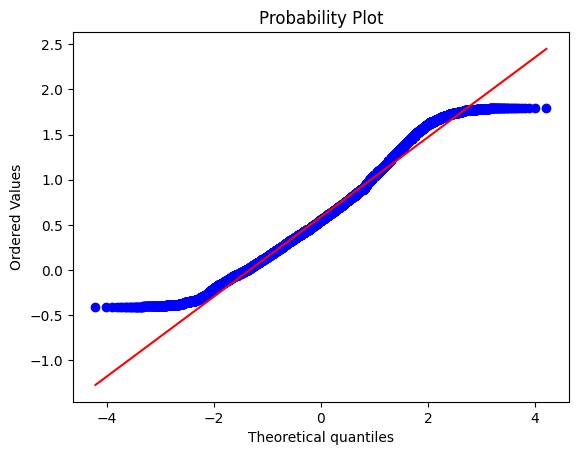

In [10]:
from scipy import stats
data_log = scaler.fit_transform(data)
df_log = pd.DataFrame(data_log, columns=data.columns)
df_log['sale_price'] = np.log1p(df_log['sale_price']+1)
sns.histplot(df_log['sale_price'], bins=50,edgecolor = "k", kde=True)
fig = plt.figure()
res = stats.probplot(df_log['sale_price'], plot=plt)

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
xgbt = XGBRegressor()
lm = LinearRegression()
ridge = Ridge()
lasso = Lasso()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
dtree = DecisionTreeRegressor()
mlp = MLPRegressor()
algo = [xgbt,lm,ridge,lasso,knn,rf,dtree,mlp]
result = []
X = df_log.drop(columns=['sale_price'])
y = df_log['sale_price']
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#y = scaler.fit_transform(y.values.reshape(-1,1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for i in algo:
    start = time.process_time()
    model = i.fit(X_train,y_train)
    result.append([str(i).split("(")[0] + str("_processed"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
    print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sec")
        
result_second_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")


XGBRegressor ✓     3.734375 sec
LinearRegression ✓     0.921875 sec
Ridge ✓     0.25 sec
Lasso ✓     0.015625 sec
KNeighborsRegressor ✓     28.734375 sec
RandomForestRegressor ✓     38.578125 sec
DecisionTreeRegressor ✓     0.59375 sec
MLPRegressor ✓     4.671875 sec


In [12]:
result_second_model

,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
RandomForestRegressor_processed,0.952541,0.642189,0.096964,0.265624,0.066084,0.181202
XGBRegressor_processed,0.760207,0.629757,0.217957,0.270199,0.155745,0.186556
MLPRegressor_processed,0.549245,0.507356,0.298829,0.311679,0.215383,0.222798
KNeighborsRegressor_processed,0.672622,0.486240,0.254670,0.318288,0.182152,0.227124
DecisionTreeRegressor_processed,0.999080,0.355400,0.013498,0.356522,0.000572,0.237875
LinearRegression_processed,0.144705,0.145367,0.411633,0.410517,0.325093,0.324480
Ridge_processed,0.144618,0.144871,0.411654,0.410636,0.325180,0.324609
Lasso_processed,0.000000,-0.000038,0.445094,0.444068,0.353593,0.352099


In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16]
}

rf = RandomForestRegressor(random_state = 42)

rf_tuned = GridSearchCV(estimator = rf,
                            param_grid = param_grid,
                            cv = 2,
                            n_jobs=-1,
                        verbose=0)

rf_tuned.fit(X_train, y_train)
rf_tuned.best_estimator_

RandomForestRegressor(max_depth=50, max_features=10, n_estimators=300,
                      random_state=42)

In [14]:
model = rf_tuned.best_estimator_.fit(X_train,y_train)

In [15]:
result_optimize_model = []
result_optimize_model.append(["RandomForestRegressor Optimize", model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])

res = pd.DataFrame(result_optimize_model, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")

In [16]:
res

,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
RandomForestRegressor Optimize,0.95503,0.651643,0.094387,0.262092,0.06473,0.17911


In [17]:
data_ = df_log.drop(columns=['sale_price'])
rankings = model.feature_importances_.tolist()
importance= pd.DataFrame(sorted(zip(data_.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)

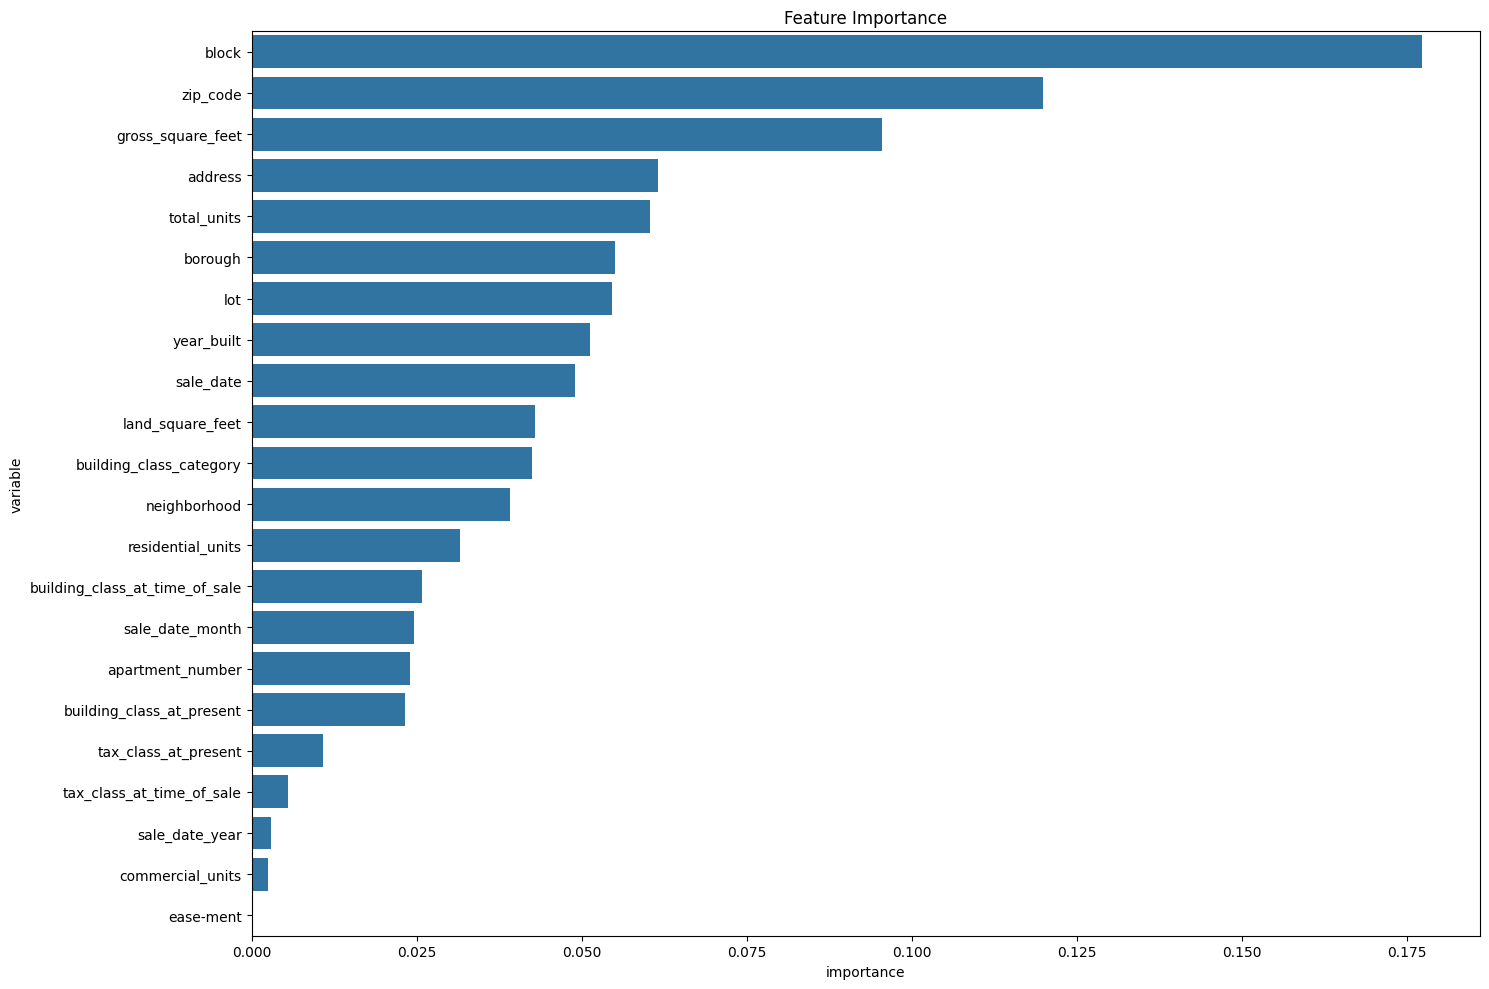

In [18]:
plt.figure(figsize=(15,10))
sns.barplot(x="importance",
            y="variable",
            data=importance)
plt.title('Feature Importance')
plt.tight_layout()

**With Selected Features**

In [19]:
drop_columns = ['ease-ment', 'apartment_number','address','sale_date','sale_date_month','zip_code']
df_selected= df_log.drop(columns=drop_columns)
df_selected.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'building_class_at_present',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date_year'],
      dtype='object')

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
xgbt = XGBRegressor()
lm = LinearRegression()
ridge = Ridge()
lasso = Lasso()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
dtree = DecisionTreeRegressor()
mlp = MLPRegressor()
algo = [xgbt,lm,ridge,lasso,knn,rf,dtree,mlp]
result = []
X = df_selected.drop(columns=['sale_price'])
y = df_selected['sale_price']
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#y = scaler.fit_transform(y.values.reshape(-1,1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for i in algo:
    start = time.process_time()
    model = i.fit(X_train,y_train)
    result.append([str(i).split("(")[0] + str("_processed"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
    print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sec")
        
result_second_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")

XGBRegressor ✓     2.5625 sec
LinearRegression ✓     0.421875 sec
Ridge ✓     0.34375 sec
Lasso ✓     0.109375 sec
KNeighborsRegressor ✓     24.859375 sec
RandomForestRegressor ✓     24.875 sec
DecisionTreeRegressor ✓     0.375 sec
MLPRegressor ✓     3.125 sec


In [21]:
result_second_model

,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
RandomForestRegressor_processed,0.921024,0.628004,0.125084,0.270838,0.080934,0.183578
XGBRegressor_processed,0.731918,0.621259,0.230455,0.273282,0.164264,0.188958
KNeighborsRegressor_processed,0.716957,0.552337,0.236798,0.297109,0.164521,0.205138
MLPRegressor_processed,0.518407,0.492747,0.308882,0.316266,0.221452,0.225853
DecisionTreeRegressor_processed,0.958763,0.406385,0.090385,0.342132,0.029118,0.227614
LinearRegression_processed,0.137564,0.139745,0.413348,0.411864,0.326798,0.325021
Ridge_processed,0.137497,0.139352,0.413364,0.411959,0.326859,0.325138
Lasso_processed,0.000000,-0.000038,0.445094,0.444068,0.353593,0.352099


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16]
}

rf = RandomForestRegressor(random_state = 42)

rf_tuned = GridSearchCV(estimator = rf,
                            param_grid = param_grid,
                            cv = 2,
                            n_jobs=-1,
                        verbose=0)

rf_tuned.fit(X_train, y_train)
rf_tuned.best_estimator_

In [38]:
model = rf_tuned.best_estimator_.fit(X_train,y_train)

In [39]:
result_optimize_model = []
result_optimize_model.append(["RandomForestRegressor Optimize", model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])

res = pd.DataFrame(result_optimize_model, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")

In [40]:
res

,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
RandomForestRegressor Optimize,0.922831,0.640562,0.123644,0.266227,0.079956,0.180504


In [41]:
data_ = df_selected.drop(columns=['sale_price'])
rankings = model.feature_importances_.tolist()
importance= pd.DataFrame(sorted(zip(data_.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)

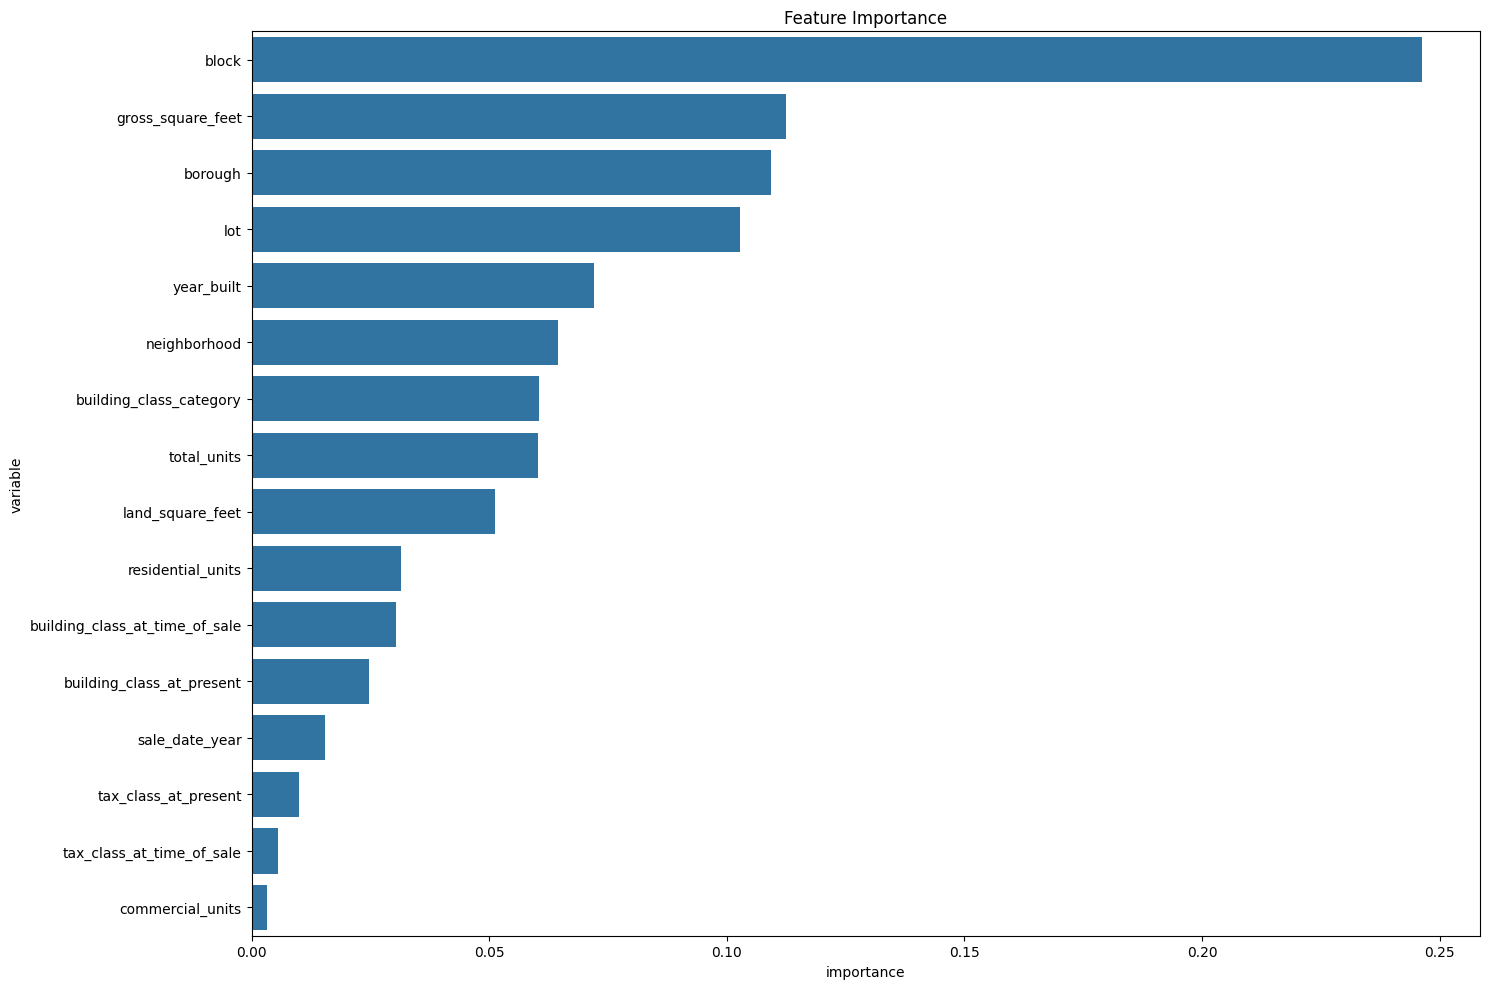

In [42]:
plt.figure(figsize=(15,10))
sns.barplot(x="importance",
            y="variable",
            data=importance)
plt.title('Feature Importance')
plt.tight_layout()